In [1]:
import pandas as pd
import numpy as np
import geopandas

##### The following is from the GeoPandas introduction tutorial on the GeoPandas [site](https://geopandas.org/en/stable/getting_started/introduction.html)

In [9]:
path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [10]:
gdf = gdf.set_index("BoroName")
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

<AxesSubplot:>

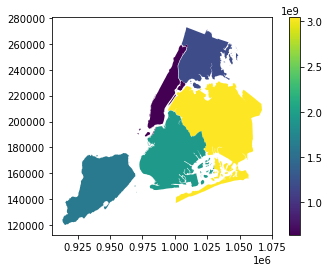

In [5]:
gdf.plot("area", legend=True)

In [77]:
# gdf.explore("area", legend=False)

In [11]:
boros = geopandas.read_file(path_to_data)


boros.BoroName

0    Staten Island
1           Queens
2         Brooklyn
3        Manhattan
4            Bronx
Name: BoroName, dtype: object

In [12]:
boro_locations = geopandas.tools.geocode(boros.BoroName)

<AxesSubplot:>

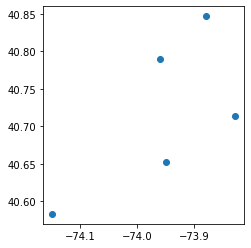

In [17]:
boro_locations.plot()

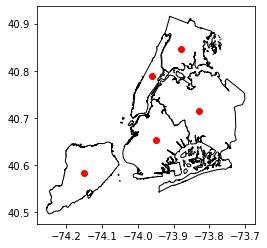

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

boros.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black");

boro_locations.plot(ax=ax, color="red");

In [60]:
covid_cases = geopandas.read_file('covid-variants.csv')

In [61]:
covid_cases

,location,date,variant,num_sequences,perc_sequences,num_sequences_total,geometry
0,Angola,2020-07-06,Alpha,0,0.0,3,None
1,Angola,2020-07-06,B.1.1.277,0,0.0,3,None
2,Angola,2020-07-06,B.1.1.302,0,0.0,3,None
3,Angola,2020-07-06,B.1.1.519,0,0.0,3,None
4,Angola,2020-07-06,B.1.160,0,0.0,3,None
...,...,...,...,...,...,...,...
100411,Zimbabwe,2021-11-01,Omicron,0,0.0,6,None
100412,Zimbabwe,2021-11-01,S:677H.Robin1,0,0.0,6,None
100413,Zimbabwe,2021-11-01,S:677P.Pelican,0,0.0,6,None
100414,Zimbabwe,2021-11-01,others,0,0.0,6,None


In [62]:
covid_cases['variant'].value_counts()

Alpha             4184
B.1.1.277         4184
others            4184
S:677P.Pelican    4184
S:677H.Robin1     4184
Omicron           4184
Mu                4184
Lambda            4184
Kappa             4184
Iota              4184
Gamma             4184
Eta               4184
Epsilon           4184
Delta             4184
Beta              4184
B.1.620           4184
B.1.367           4184
B.1.258           4184
B.1.221           4184
B.1.177           4184
B.1.160           4184
B.1.1.519         4184
B.1.1.302         4184
non_who           4184
Name: variant, dtype: int64

In [84]:
len(covid_cases['location'].unique())

121

In [63]:
omicron_cases = covid_cases[covid_cases.variant == 'Omicron']

In [64]:
omicron_cases

,location,date,variant,num_sequences,perc_sequences,num_sequences_total,geometry
19,Angola,2020-07-06,Omicron,0,0.0,3,None
43,Angola,2020-08-31,Omicron,0,0.0,1,None
67,Angola,2020-09-28,Omicron,0,0.0,10,None
91,Angola,2020-10-12,Omicron,0,0.0,29,None
115,Angola,2020-10-26,Omicron,0,0.0,7,None
...,...,...,...,...,...,...,...
100315,Zimbabwe,2021-09-06,Omicron,0,0.0,14,None
100339,Zimbabwe,2021-09-20,Omicron,0,0.0,6,None
100363,Zimbabwe,2021-10-04,Omicron,0,0.0,2,None
100387,Zimbabwe,2021-10-18,Omicron,0,0.0,5,None


In [66]:
omicron_cases[(omicron_cases['location'] == 'United States')]

,location,date,variant,num_sequences,perc_sequences,num_sequences_total,geometry
96787,United States,2020-05-11,Omicron,0,0.0,5804,None
96811,United States,2020-05-25,Omicron,0,0.0,4736,None
96835,United States,2020-06-08,Omicron,0,0.0,4035,None
96859,United States,2020-06-22,Omicron,0,0.0,6070,None
96883,United States,2020-07-06,Omicron,0,0.0,8371,None
96907,United States,2020-07-20,Omicron,0,0.0,10122,None
96931,United States,2020-08-03,Omicron,0,0.0,7801,None
96955,United States,2020-08-17,Omicron,0,0.0,5992,None
96979,United States,2020-08-31,Omicron,0,0.0,4888,None
97003,United States,2020-09-14,Omicron,0,0.0,4362,None


In [68]:
restricted_day = omicron_cases[omicron_cases['date'] == '2021-12-27']

In [71]:
restricted_day

,location,date,variant,num_sequences,perc_sequences,num_sequences_total,geometry
1723,Argentina,2021-12-27,Omicron,80,85.11,94,None
3379,Australia,2021-12-27,Omicron,1319,76.42,1726,None
6163,Bangladesh,2021-12-27,Omicron,4,16.67,24,None
7243,Belgium,2021-12-27,Omicron,464,31.08,1493,None
9859,Botswana,2021-12-27,Omicron,142,99.3,143,None
...,...,...,...,...,...,...,...
95107,Ukraine,2021-12-27,Omicron,1,100.0,1,None
96739,United Kingdom,2021-12-27,Omicron,52456,65.57,80002,None
97819,United States,2021-12-27,Omicron,24681,50.13,49235,None
98923,Vietnam,2021-12-27,Omicron,1,2.0,50,None


In [69]:
country_locations = geopandas.tools.geocode(restricted_day.location)

In [70]:
country_locations

,geometry,address
1723,POINT (-64.96728 -34.99650),"Argentina, Argentina"
3379,POINT (134.75500 -24.77611),"Australia, Australia"
6163,POINT (90.29344 24.47693),"বাংলাদেশ, বাংলাদেশ"
7243,POINT (4.66671 50.64028),"België / Belgique / Belgien, België / Belgique..."
9859,POINT (24.59287 -23.16818),"Botswana, Botswana"
...,...,...
95107,POINT (31.27183 49.48720),"Україна, Україна"
96739,POINT (-3.27658 54.70235),"United Kingdom, United Kingdom"
97819,POINT (-100.44588 39.78373),"United States, United States"
98923,POINT (108.42651 13.29040),"Việt Nam, Việt Nam"


In [73]:
restricted_day.index.equals(country_locations.index)

True

In [74]:
restricted_day['geometry'] = country_locations['geometry']

In [96]:
#restricted_day.explore()

In [88]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [91]:
world = world[['name', 'geometry']]
world.head()

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [94]:
world = world.set_index('name')
restricted_day = restricted_day.set_index('location')

In [95]:
world

,geometry
name,
Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...
Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [120]:
from geopy.geocoders import Photon

temp_photon = Photon()

morocco = temp_photon.geocode("Morocco", exactly_one=False)[1]
swizerland = temp_photon.geocode("Switzerland", exactly_one=False)[1]
georgia = temp_photon.geocode("Georgia", exactly_one=False)[1]

In [121]:
georgia


Location(South Georgia, South Georgia and the South Sandwich Islands, (-54.447489000000004, -36.59801166090867, 0.0))